# Trauma Transfer Learning Experiment

This notebook compares baseline survival models and a transfer learning approach using Indian and Jordan trauma datasets.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
#
sns.set(style='whitegrid')


## Load datasets

In [36]:
india_file = 'trauma_india_brain_injury.csv'
jordan_file = 'traumatic_brain_injury.csv'
florida_file = 'updated_dataset (1).csv'
california_file = 'traumatic_brain_injury_usa.csv'


cols_india = ['age','sex','sbp_1','hr_1','rr_1','gcs_t_1','doa','toa','dodd','todd','moi','died']
india = pd.read_csv(india_file, usecols=cols_india)

cols_jordan = ['Gender','age of diagnosis','ER-HR','ER-RR','ER-systolic BP','GCS in ER','type of trauma','length of stay in the hospital (in days)','outcome']
jordan = pd.read_csv(jordan_file, usecols=cols_jordan)

cols_florida = ['Age', 'Gender', 'SBP', 'HR', 'RR', 'MOI', 'GCS', 'Hospital LOS Days']
florida = pd.read_csv(florida_file, usecols=cols_florida)

cols_california = ['Age', 'Sex', 'SBP', 'HR', 'RR', 'Cause of Injury', 'Trauma GCS', 'LOS']
california = pd.read_csv(california_file, usecols=cols_california)

In [37]:
india_unique = india['moi'].dropna().astype(str).str.strip().unique()
jordan_unique = jordan['type of trauma'].dropna().astype(str).str.strip().unique()
florida_unique = florida['MOI'].dropna().astype(str).str.strip().unique()
california_unique = california['Cause of Injury'].dropna().astype(str).str.strip().unique()

# Print unique values for each dataset
print("🇮🇳 India - Unique MOI values:")
print(sorted(india_unique), "\n")

print("🇯🇴 Jordan - Unique 'type of trauma' values:")
print(sorted(jordan_unique), "\n")

print("🇺🇸 Florida - Unique MOI values:")
print(sorted(florida_unique), "\n")

print("🇺🇸 California - Unique 'Cause of Injury' values:")
print(sorted(california_unique), "\n")

🇮🇳 India - Unique MOI values:
['Assault', 'Burn', 'Fall', 'Other', 'Railway injury', 'Road traffic injury (bicyclist)', 'Road traffic injury (driver)', 'Road traffic injury (motorcyclist)', 'Road traffic injury (passenger)', 'Road traffic injury (pedestrian)', 'Road traffic injury (unspecified)'] 

🇯🇴 Jordan - Unique 'type of trauma' values:
['Blast injury', 'Falling down', 'RTA', 'RTA(PEDASTRAIN)', 'RTA(back seated)', 'RTA(first seat)', 'falling down', 'struck by a heavy object'] 

🇺🇸 Florida - Unique MOI values:
['ASSAULT', 'Assault', 'Bike rider from auto', 'FALL FROM BIKE', 'Fall Downstairs', 'Flipped ATV injury', 'GROUND LEVEL FALL', 'GSW', 'Ground Level Fall', 'Ground leve fall', 'HIT BY TRAIN', 'MOTORCYCLE CRASH HELMETED', 'MOTORCYCLIST', 'MVA', 'MVA  Driver', 'MVA Driver', 'MVA Passenger', 'MVA driver', 'MVA driver ejected', 'MVA driver restrained', 'MVA passenger', 'MVA passenger Front', 'MVA restrained driver', 'MVA restrained front passenger', 'MVA restrained passenger', 'MV

In [38]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Select only numeric columns for imputation
jordan_numeric = jordan.select_dtypes(include=[np.number])

# Perform iterative imputation
imputer = IterativeImputer(random_state=0)
jordan_imputed_array = imputer.fit_transform(jordan_numeric)

# Replace numeric columns in jordan with imputed values
jordan[jordan_numeric.columns] = jordan_imputed_array

print(jordan.head())

   Gender  age of diagnosis   type of trauma  GCS in ER        ER-HR  \
0  Female               6.0  RTA(PEDASTRAIN)       15.0  tachycardia   
1    Male               7.0  RTA(PEDASTRAIN)       15.0       normal   
2    Male              13.0     falling down        3.0       normal   
3    Male               9.0              RTA       13.0       normal   
4    Male               1.5     falling down       15.0       normal   

       ER-RR ER-systolic BP  length of stay in the hospital (in days)  \
0  tachypnea         normal                                       5.0   
1     normal         normal                                       7.0   
2     normal         normal                                       7.0   
3     normal         normal                                      28.0   
4     normal         normal                                       3.0   

    outcome  
0  survival  
1  survival  
2  survival  
3  survival  
4  survival  


## Feature engineering

In [39]:
# Pediatric reference ranges (example, adjust as needed for your population)
def hr_category(age, hr):
    # Age in years, HR in bpm
    if pd.isnull(hr) or pd.isnull(age):
        return np.nan
    if age < 1:
        if hr > 160: return 'tachycardia'
        else: return 'normal'
    elif age < 3:
        if hr > 150: return 'tachycardia'
        else: return 'normal'
    elif age < 6:
        if hr > 140: return 'tachycardia'
        else: return 'normal'
    elif age < 12:
        if hr > 120: return 'tachycardia'
        else: return 'normal'
    else:
        if hr > 100: return 'tachycardia'
        else: return 'normal'

def rr_category(age, rr):
    # Age in years, RR in breaths/min
    if pd.isnull(rr) or pd.isnull(age):
        return np.nan
    if age < 1:
        if rr > 60: return 'tachypnea'
        else: return 'normal'
    elif age < 3:
        if rr > 40: return 'tachypnea'
        else: return 'normal'
    elif age < 6:
        if rr > 34: return 'tachypnea'
        else: return 'normal'
    elif age < 12:
        if rr > 30: return 'tachypnea'
        else: return 'normal'
    else:
        if rr > 20: return 'tachypnea'
        else: return 'normal'

def sbp_category(age, sbp):
    # Age in years, SBP in mmHg
    if pd.isnull(sbp) or pd.isnull(age):
        return np.nan
    if age < 1:
        if sbp < 70: return 'low'
        else: return 'normal'
    elif age < 10:
        if sbp < 70 + 2*age: return 'low'
        else: return 'normal'
    else:
        if sbp < 90: return 'low'
        else: return 'normal'



In [40]:
def map_moi(text):
    if pd.isnull(text):
        return "Other / Unknown"

    text = str(text).strip().lower()

    if any(kw in text for kw in ['mva', 'mvc', 'vehicle', 'driver', 'passenger', 'auto', 'car', 'rollover']):
        return "Motor Vehicle Collision"
    if 'motorcycle' in text or 'motorcyclist' in text or 'motocycle' in text:
        return "Motorcycle Crash"
    if 'pedestrian' in text or 'peds vs auto' in text:
        return "Pedestrian Struck"
    if 'bicycle' in text or 'bicyclist' in text or 'bike' in text:
        return "Bicycle Crash"
    if 'fall' in text or 'fell' in text or 'found down' in text or 'stairs' in text or 'roof' in text:
        return "Fall"
    if 'assault' in text or 'struck' in text or 'stab' in text or 'hit' in text or 'pole' in text or 'collision with horse' in text:
        return "Assault / Blunt Force"
    if 'gsw' in text:
        return "Gunshot Wound (GSW)"
    if 'fire' in text or 'burn' in text or 'blast' in text or 'explosion' in text:
        return "Burn / Fire / Blast"
    if 'alligator' in text or 'boat' in text or 'atv' in text or 'golf cart' in text or 'found by the side of the road' in text:
        return "Animal / Environmental"
    
    return "Other / Unknown"


In [41]:
india['moi_category'] = india['moi'].apply(map_moi)
jordan['moi_category'] = jordan['type of trauma'].apply(map_moi)
florida['moi_category'] = florida['MOI'].apply(map_moi)
california['moi_category'] = california['Cause of Injury'].apply(map_moi)


In [42]:
def normalize_india_moi(moi):
    """
    Consolidates India's MOI categories:
    Groups motorcyclist, bicyclist, unspecified under 'unspecified'.
    """
    if pd.isnull(moi):
        return 'Unmapped'

    moi = moi.strip()

    if moi in [
        'Road traffic injury (motorcyclist)',
        'Road traffic injury (bicyclist)',
        'Road traffic injury (unspecified)'
    ]:
        return 'Road traffic injury (unspecified)'

    return moi


In [43]:
def get_mode_of_injury(jordan_trauma):
    """
    Maps Jordan 'type of trauma' value to India-style 'mode_of_injury'.

    Parameters:
    - jordan_trauma: string

    Returns:
    - Standardized MOI string (India format) or 'Unmapped'
    """
    if pd.isnull(jordan_trauma):
        return 'Unmapped'
    
    mapping = {
        'RTA(PEDASTRAIN)': 'Road traffic injury (pedestrian)',
        'Falling down': 'Fall',
        'falling down': 'Fall',
        'RTA': 'Road traffic injury (unspecified)',
        'RTA ': 'Road traffic injury (unspecified)',
        'RTA(back seated)': 'Road traffic injury (passenger)',
        'RTA(first seat)': 'Road traffic injury (driver)',
        'Blast injury': 'Burn',
        'struck by a heavy object': 'Assault'
    }

    return mapping.get(jordan_trauma.strip(), 'Unmapped')


In [44]:
# Rename columns for consistency
florida = florida.rename(columns={
    'Age': 'age',
    'Gender': 'sex',
    'SBP': 'sbp',
    'HR': 'hr',
    'RR': 'rr',
    'GCS': 'gcs',
    'MOI': 'source',
    'Hospital LOS Days': 'los'
})

california = california.rename(columns={
    'Age': 'age',
    'Sex': 'sex',
    'SBP': 'sbp',
    'HR': 'hr',
    'RR': 'rr',
    'Trauma GCS': 'gcs',
    'Cause of Injury': 'source',
    'LOS': 'los'
})

# Convert vitals to numeric
for df in [florida, california]:
    df['hr'] = pd.to_numeric(df['hr'], errors='coerce')
    df['rr'] = pd.to_numeric(df['rr'], errors='coerce')
    df['sbp'] = pd.to_numeric(df['sbp'], errors='coerce')
    df['age'] = pd.to_numeric(df['age'], errors='coerce')
    df['gcs'] = pd.to_numeric(df['gcs'], errors='coerce')
    df['sex'] = df['sex'].map({'Male': 1, 'Female': 0})

florida['moi_category'] = florida['source'].apply(map_moi)
california['moi_category'] = california['source'].apply(map_moi)

# Apply pediatric categorization to each
for df in [florida, california]:
    df['hr_cat'] = [hr_category(a, h) for a, h in zip(df['age'], df['hr'])]
    df['rr_cat'] = [rr_category(a, r) for a, r in zip(df['age'], df['rr'])]
    df['sbp_cat'] = [sbp_category(a, s) for a, s in zip(df['age'], df['sbp'])]

    


In [45]:
"""india['moi'] = india['moi'].apply(normalize_india_moi)
exclude_moi = ['Railway injury', 'Other', 'Unmapped']
india = india[~india['moi'].isin(exclude_moi)].copy()
"""

"india['moi'] = india['moi'].apply(normalize_india_moi)\nexclude_moi = ['Railway injury', 'Other', 'Unmapped']\nindia = india[~india['moi'].isin(exclude_moi)].copy()\n"

In [46]:
"""jordan['type of trauma'] = jordan['type of trauma'].apply(get_mode_of_injury)
jordan= jordan[~jordan['type of trauma'].isin(exclude_moi)].copy()
"""

"jordan['type of trauma'] = jordan['type of trauma'].apply(get_mode_of_injury)\njordan= jordan[~jordan['type of trauma'].isin(exclude_moi)].copy()\n"

In [47]:
def parse_datetime(date_col, time_col):
    dt = pd.to_datetime(date_col + ' ' + time_col, errors='coerce')
    return dt

india['admit_time'] = parse_datetime(india['doa'], india['toa'])
india['discharge_time'] = parse_datetime(india['dodd'], india['todd'])
india['los'] = (india['discharge_time'] - india['admit_time']).dt.total_seconds() / 3600
india['los'] = india['los'].fillna(0)
india['event'] = (india['died'] == 'Yes').astype(int)

jordan['los'] = pd.to_numeric(jordan['length of stay in the hospital (in days)'], errors='coerce')
jordan['event'] = (jordan['outcome'] == 'died').astype(int)

india['sex'] = india['sex'].map({'Male':1,'Female':0})
jordan['Gender'] = jordan['Gender'].map({'Male':1,'Female':0})

features_india = india[['age','sex','sbp_1','hr_1','rr_1','gcs_t_1','moi']].copy()
features_jordan = jordan[['age of diagnosis','Gender','ER-HR','ER-RR','ER-systolic BP','GCS in ER','type of trauma']].copy()
features_jordan.columns = ['age','sex','hr','rr','sbp','gcs','source']
features_india.columns = ['age','sex','sbp','hr','rr','gcs','source']


C:\Users\SJ\AppData\Local\Temp\ipykernel_63220\3600371442.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt = pd.to_datetime(date_col + ' ' + time_col, errors='coerce')
C:\Users\SJ\AppData\Local\Temp\ipykernel_63220\3600371442.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt = pd.to_datetime(date_col + ' ' + time_col, errors='coerce')


In [48]:
# Ensure numeric conversion for Indian vital signs before categorization
features_india['hr'] = pd.to_numeric(features_india['hr'], errors='coerce')
features_india['rr'] = pd.to_numeric(features_india['rr'], errors='coerce')
features_india['sbp'] = pd.to_numeric(features_india['sbp'], errors='coerce')
features_india['age'] = pd.to_numeric(features_india['age'], errors='coerce')

# Now apply the categorization functions
features_india['hr_cat'] = [hr_category(a, h) for a, h in zip(features_india['age'], features_india['hr'])]
features_india['rr_cat'] = [rr_category(a, r) for a, r in zip(features_india['age'], features_india['rr'])]
features_india['sbp_cat'] = [sbp_category(a, s) for a, s in zip(features_india['age'], features_india['sbp'])]

# For Jordan, use the existing categorical columns (assumed to be ER-HR, ER-RR, ER-systolic BP)
features_jordan['hr_cat'] = features_jordan['hr']
features_jordan['rr_cat'] = features_jordan['rr']
features_jordan['sbp_cat'] = features_jordan['sbp']


# Use correct argument for OneHotEncoder for scikit-learn >= 1.2
from sklearn.preprocessing import OneHotEncoder

cat_cols = ['hr_cat', 'rr_cat', 'sbp_cat','source']
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit on combined categories to ensure same columns
enc.fit(pd.concat([features_india[cat_cols], features_jordan[cat_cols]], axis=0))

X_india_cat = enc.transform(features_india[cat_cols])
X_jordan_cat = enc.transform(features_jordan[cat_cols])

# Replace original columns with encoded
import numpy as np
X_india_final = np.concatenate([features_india[['age','sex','gcs']].fillna(0).values, X_india_cat], axis=1)
X_jordan_final = np.concatenate([features_jordan[['age','sex','gcs']].fillna(0).values, X_jordan_cat], axis=1)

# Update y as before
y_india = np.array([(bool(e), t) for e,t in zip(india['event'], india['los']/24)], dtype=[('event', bool), ('time', float)])
y_jordan = np.array([(bool(e), t) for e,t in zip(jordan['event'], jordan['los'])], dtype=[('event', bool), ('time', float)])


In [49]:

features_florida = florida[['age', 'sex', 'gcs', 'hr_cat', 'rr_cat', 'sbp_cat', 'moi_category']].copy()
features_california = california[['age', 'sex', 'gcs', 'hr_cat', 'rr_cat', 'sbp_cat', 'moi_category']].copy()

# Rename moi_category → source to match encoder expectations
features_florida = features_florida.rename(columns={"moi_category": "source"})
features_california = features_california.rename(columns={"moi_category": "source"})

# Now transform
X_florida_cat = enc.transform(features_florida[['hr_cat', 'rr_cat', 'sbp_cat', 'source']])
X_california_cat = enc.transform(features_california[['hr_cat', 'rr_cat', 'sbp_cat', 'source']])


X_florida_final = np.concatenate([features_florida[['age', 'sex', 'gcs']].fillna(0).values, X_florida_cat], axis=1)
X_california_final = np.concatenate([features_california[['age', 'sex', 'gcs']].fillna(0).values, X_california_cat], axis=1)



In [51]:
# List of datasets
datasets = {
    "India": features_india,
    "Jordan": features_jordan,
    "Florida": features_florida,
    "California": features_california
}

# Display head + check for missing values
for name, df in datasets.items():
    print(f"\n🟦 {name} Dataset (head):")
    display(df.head())

    print(f"\n🔍 {name} - Missing Values:")
    print(df.isnull().sum())
    print("-" * 50)



🟦 India Dataset (head):


,age,sex,sbp,hr,rr,gcs,source,hr_cat,rr_cat,sbp_cat
0,40.0,1,120.0,70.0,22.0,15.0,Fall,normal,tachypnea,normal
1,27.0,1,130.0,84.0,15.0,5.0,Road traffic injury (unspecified),normal,normal,normal
2,45.0,1,110.0,80.0,NaN,15.0,Road traffic injury (unspecified),normal,NaN,normal
3,50.0,1,NaN,88.0,24.0,4.0,Railway injury,normal,tachypnea,NaN
4,50.0,0,130.0,80.0,22.0,3.0,Railway injury,normal,tachypnea,normal



🔍 India - Missing Values:
age          10
sex           0
sbp        1691
hr         1125
rr         3820
gcs         460
source       33
hr_cat     1133
rr_cat     3823
sbp_cat    1699
dtype: int64
--------------------------------------------------

🟦 Jordan Dataset (head):


,age,sex,hr,rr,sbp,gcs,source,hr_cat,rr_cat,sbp_cat
0,6.0,0.0,tachycardia,tachypnea,normal,15.0,RTA(PEDASTRAIN),tachycardia,tachypnea,normal
1,7.0,1.0,normal,normal,normal,15.0,RTA(PEDASTRAIN),normal,normal,normal
2,13.0,1.0,normal,normal,normal,3.0,falling down,normal,normal,normal
3,9.0,1.0,normal,normal,normal,13.0,RTA,normal,normal,normal
4,1.5,1.0,normal,normal,normal,15.0,falling down,normal,normal,normal



🔍 Jordan - Missing Values:
age        0
sex        3
hr         0
rr         0
sbp        0
gcs        0
source     5
hr_cat     0
rr_cat     0
sbp_cat    0
dtype: int64
--------------------------------------------------

🟦 Florida Dataset (head):


,age,sex,gcs,hr_cat,rr_cat,sbp_cat,source
0,23,NaN,3,tachycardia,normal,normal,Motor Vehicle Collision
1,53,NaN,15,tachycardia,normal,normal,Fall
2,34,NaN,6,tachycardia,tachypnea,normal,Pedestrian Struck
3,35,NaN,7,tachycardia,normal,normal,Motor Vehicle Collision
4,71,NaN,3,tachycardia,normal,normal,Gunshot Wound (GSW)



🔍 Florida - Missing Values:
age          0
sex        263
gcs          0
hr_cat       1
rr_cat       1
sbp_cat      1
source       0
dtype: int64
--------------------------------------------------

🟦 California Dataset (head):


,age,sex,gcs,hr_cat,rr_cat,sbp_cat,source
0,60,NaN,14.0,tachycardia,tachypnea,normal,Gunshot Wound (GSW)
1,38,NaN,3.0,tachycardia,normal,low,Motor Vehicle Collision
2,61,NaN,14.0,normal,normal,normal,Motor Vehicle Collision
3,62,NaN,14.0,normal,normal,normal,Motor Vehicle Collision
4,22,NaN,3.0,normal,normal,normal,Motor Vehicle Collision



🔍 California - Missing Values:
age          0
sex        583
gcs          2
hr_cat       2
rr_cat       3
sbp_cat      2
source       0
dtype: int64
--------------------------------------------------


## Exploratory analysis

India rows: 7301
Jordan rows: 107
Indian LOS summary (hours):
count    7301.000000
mean      168.716537
std       308.287605
min      -240.000000
25%        43.500000
50%       108.833333
75%       191.666667
max      8936.333333
Name: los, dtype: float64
Jordan LOS summary (days):
count    107.000000
mean      11.906265
std       16.151716
min        1.000000
25%        4.000000
50%        7.000000
75%       12.000000
max      126.000000
Name: los, dtype: float64


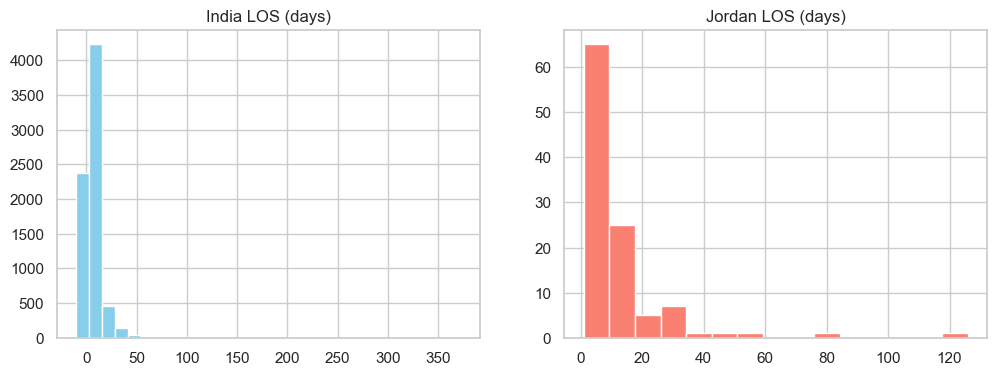

In [ ]:
print('India rows:', len(india))
print('Jordan rows:', len(jordan))

print('Indian LOS summary (hours):')
print(india['los'].describe())
print('Jordan LOS summary (days):')
print(jordan['los'].describe())

fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(india['los']/24, bins=30, color='skyblue')
axes[0].set_title('India LOS (days)')
axes[1].hist(jordan['los'], bins=15, color='salmon')
axes[1].set_title('Jordan LOS (days)')
plt.show()


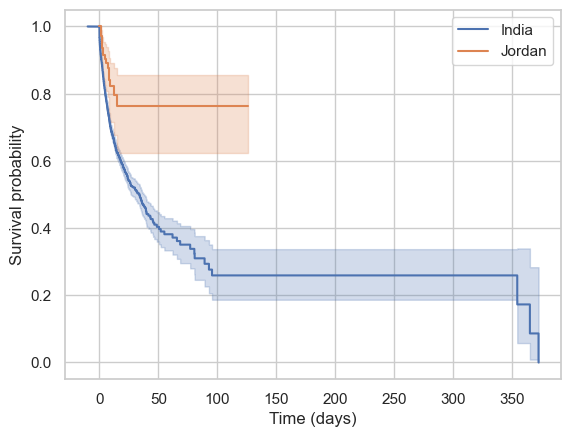

In [ ]:
kmf = KaplanMeierFitter()
kmf.fit(durations=india['los']/24, event_observed=india['event'], label='India')
ax = kmf.plot()
kmf.fit(durations=jordan['los'], event_observed=jordan['event'], label='Jordan')
kmf.plot(ax=ax)
ax.set_xlabel('Time (days)')
ax.set_ylabel('Survival probability')
plt.show()


## Baseline Cox model on Jordan data

# Use only numeric and one-hot encoded features for CoxPHFitter
# Use X_jordan_final (age, sex, gcs, one-hot encoded vitals) for baseline Cox model
import pandas as pd

# Create DataFrame for CoxPHFitter
baseline_data = pd.DataFrame(X_jordan_final, columns=['age','sex','gcs'] + list(enc.get_feature_names_out(cat_cols)))
baseline_data['duration'] = jordan['los'].values
baseline_data['event'] = jordan['event'].values



# Remove one-hot columns that are perfectly collinear (sum to 1 across all rows)
def drop_perfectly_collinear_onehot(df, base_cols):
    # Only keep one column per one-hot group
    keep = set(base_cols)
    for prefix in [c.split('_')[0] for c in df.columns if '_' in c]:
        group = [c for c in df.columns if c.startswith(prefix+'_')]
        if len(group) > 1:
            # Keep only the first column in the group
            keep.update(group[:1])
    return df[list(keep)]

# Identify base columns (age, sex, gcs, duration, event)
base_cols = {'age','sex','gcs','duration','event'}

# Apply to Jordan
baseline_data = pd.DataFrame(X_jordan_final, columns=['age','sex','gcs'] + list(enc.get_feature_names_out(cat_cols)))
baseline_data['duration'] = jordan['los'].values
baseline_data['event'] = jordan['event'].values
baseline_data = drop_perfectly_collinear_onehot(baseline_data, base_cols)

cph = CoxPHFitter()
cph.fit(baseline_data, duration_col='duration', event_col='event')
print(cph.summary)
print('Baseline C-index:', concordance_index(baseline_data['duration'], -cph.predict_partial_hazard(baseline_data), baseline_data['event']))


## Transfer learning with gradient boosting

In [ ]:
# Use only numeric and one-hot encoded features for gradient boosting survival analysis
# Use X_jordan_final and X_india_final, not features_jordan or features_india (which contain strings)

# Remove samples with negative or zero LOS for survival analysis
# (Observed time must be positive)

# For India
valid_india = india['los'] > 0
X_india_gb = X_india_final[valid_india.values]
y_india = np.array([(bool(e), t) for e, t in zip(india.loc[valid_india, 'event'], india.loc[valid_india, 'los']/24)], dtype=[('event', bool), ('time', float)])

# For Jordan
valid_jordan = jordan['los'] > 0
X_jordan_gb = X_jordan_final[valid_jordan.values]
y_jordan = np.array([(bool(e), t) for e, t in zip(jordan.loc[valid_jordan, 'event'], jordan.loc[valid_jordan, 'los'])], dtype=[('event', bool), ('time', float)])

"""# Baseline without transfer
gb_baseline = GradientBoostingSurvivalAnalysis(random_state=0)
gb_baseline.fit(X_jordan_gb, y_jordan)
base_cindex = gb_baseline.score(X_jordan_gb, y_jordan)
print('Baseline gradient boosting C-index:', base_cindex)

# Pretrain on India then fine-tune on Jordan
gb_transfer = GradientBoostingSurvivalAnalysis(random_state=0, n_estimators=100, warm_start=True)
gb_transfer.fit(X_india_gb, y_india)
gb_transfer.set_params(n_estimators=150)
gb_transfer.fit(X_jordan_gb, y_jordan)
transfer_cindex = gb_transfer.score(X_jordan_gb, y_jordan)
print('Transfer learning C-index:', transfer_cindex)

# Plot example predicted survival curves for Jordan
import matplotlib.pyplot as plt
for fn in gb_transfer.predict_survival_function(X_jordan_gb[:5]):
    plt.step(fn.x, fn.y)
plt.xlabel('Time (days)')
plt.ylabel('Survival probability')
plt.title('Example predicted curves (Jordan)')
plt.show()"""

"# Baseline without transfer\ngb_baseline = GradientBoostingSurvivalAnalysis(random_state=0)\ngb_baseline.fit(X_jordan_gb, y_jordan)\nbase_cindex = gb_baseline.score(X_jordan_gb, y_jordan)\nprint('Baseline gradient boosting C-index:', base_cindex)\n\n# Pretrain on India then fine-tune on Jordan\ngb_transfer = GradientBoostingSurvivalAnalysis(random_state=0, n_estimators=100, warm_start=True)\ngb_transfer.fit(X_india_gb, y_india)\ngb_transfer.set_params(n_estimators=150)\ngb_transfer.fit(X_jordan_gb, y_jordan)\ntransfer_cindex = gb_transfer.score(X_jordan_gb, y_jordan)\nprint('Transfer learning C-index:', transfer_cindex)\n\n# Plot example predicted survival curves for Jordan\nimport matplotlib.pyplot as plt\nfor fn in gb_transfer.predict_survival_function(X_jordan_gb[:5]):\n    plt.step(fn.x, fn.y)\nplt.xlabel('Time (days)')\nplt.ylabel('Survival probability')\nplt.title('Example predicted curves (Jordan)')\nplt.show()"

## Robust Transfer Learning Evaluation: 5-Fold Cross-Validation Only

We now evaluate transfer learning using only 5-fold cross-validation (CV) for all models. Both the baseline (Jordan only) and transfer learning (pretrain India, fine-tune Jordan) models are compared using mean C-index and standard deviation across CV folds. This approach ensures robust, publication-quality model evaluation and avoids bias from a single holdout split.

In [ ]:
""""""'''"""from sklearn.model_selection import KFold
from sksurv.metrics import concordance_index_censored
import numpy as np

# Remove samples with negative or zero LOS for survival analysis
valid_jordan = jordan['los'] > 0
X_jordan_gb = X_jordan_final[valid_jordan.values]
y_jordan = np.array([(bool(e), t) for e, t in zip(jordan.loc[valid_jordan, 'event'], jordan.loc[valid_jordan, 'los'])], dtype=[('event', bool), ('time', float)])

valid_india = india['los'] > 0
X_india_gb = X_india_final[valid_india.values]
y_india = np.array([(bool(e), t) for e, t in zip(india.loc[valid_india, 'event'], india.loc[valid_india, 'los']/24)], dtype=[('event', bool), ('time', float)])

# Cross-validation (5-fold) on Jordan
def crossval_cindex_transfer(X_source, y_source, X_target, y_target, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    cindices = []
    for train_idx, test_idx in kf.split(X_target):
        gb_transfer = GradientBoostingSurvivalAnalysis(random_state=0, n_estimators=100, warm_start=True)
        gb_transfer.fit(X_source, y_source)
        gb_transfer.set_params(n_estimators=150)
        gb_transfer.fit(X_target[train_idx], y_target[train_idx])
        cindices.append(gb_transfer.score(X_target[test_idx], y_target[test_idx]))
    return np.mean(cindices), np.std(cindices)

def crossval_cindex_baseline(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    cindices = []
    for train_idx, test_idx in kf.split(X):
        model_ = GradientBoostingSurvivalAnalysis(random_state=0)
        model_.fit(X[train_idx], y[train_idx])
        cindices.append(model_.score(X[test_idx], y[test_idx]))
    return np.mean(cindices), np.std(cindices)

# Baseline CV
cv_cindex_baseline_jordan, cv_cindex_baseline_std_jordan = crossval_cindex_baseline(X_jordan_gb, y_jordan)
print(f'Baseline 5-fold CV C-index: {cv_cindex_baseline_jordan:.3f} ± {cv_cindex_baseline_std_jordan:.3f}')

# Transfer learning CV
cv_cindex_transfer_jordan, cv_cindex_transfer_std_jordan = crossval_cindex_transfer(X_india_gb, y_india, X_jordan_gb, y_jordan)
print(f'Transfer learning 5-fold CV C-index: {cv_cindex_transfer_jordan:.3f} ± {cv_cindex_transfer_std_jordan:.3f}')"""'''""""""

'"""from sklearn.model_selection import KFold\nfrom sksurv.metrics import concordance_index_censored\nimport numpy as np\n\n# Remove samples with negative or zero LOS for survival analysis\nvalid_jordan = jordan[\'los\'] > 0\nX_jordan_gb = X_jordan_final[valid_jordan.values]\ny_jordan = np.array([(bool(e), t) for e, t in zip(jordan.loc[valid_jordan, \'event\'], jordan.loc[valid_jordan, \'los\'])], dtype=[(\'event\', bool), (\'time\', float)])\n\nvalid_india = india[\'los\'] > 0\nX_india_gb = X_india_final[valid_india.values]\ny_india = np.array([(bool(e), t) for e, t in zip(india.loc[valid_india, \'event\'], india.loc[valid_india, \'los\']/24)], dtype=[(\'event\', bool), (\'time\', float)])\n\n# Cross-validation (5-fold) on Jordan\ndef crossval_cindex_transfer(X_source, y_source, X_target, y_target, n_splits=5):\n    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)\n    cindices = []\n    for train_idx, test_idx in kf.split(X_target):\n        gb_transfer = GradientBoosting

## India→Jordan Transfer: Experimental Styles

We compare three approaches for evaluating on the Jordan dataset:

1. **Direct Transfer (No Fine-Tuning):**
   - Train on India only, test directly on Jordan.
2. **Standard Fine-Tuning:**
   - Pretrain on India, then fine-tune on Jordan (add trees, warm_start), test on Jordan.
3. **Weighted Fine-Tuning:**
   - Pretrain on India, then fine-tune on Jordan with higher sample weights for Jordan data, test on Jordan.

This allows for a rigorous comparison of transfer learning strategies.

In [ ]:
from sksurv.metrics import concordance_index_censored

In [ ]:
# Baseline: Train and evaluate only on Jordan (5-fold cross-validation)
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cindices = []
for train_idx, test_idx in kf.split(X_jordan_gb):
    gb_jordan = GradientBoostingSurvivalAnalysis(random_state=0, n_estimators=150)
    gb_jordan.fit(X_jordan_gb[train_idx], y_jordan[train_idx])
    preds = gb_jordan.predict(X_jordan_gb[test_idx])
    cindex = concordance_index_censored(y_jordan['event'][test_idx], y_jordan['time'][test_idx], preds)[0]
    cindices.append(cindex)
print(f'Jordan-only baseline (5-fold CV) C-index: {np.mean(cindices):.3f} ± {np.std(cindices):.3f}')

Jordan-only baseline (5-fold CV) C-index: 0.842 ± 0.166


In [ ]:
# Weighted fine-tuning: pretrain on India, fine-tune on Jordan with sample weighting, test on Jordan
from sklearn.utils import compute_sample_weight
from sklearn.model_selection import KFold
import numpy as np

# Weighted fine-tuning (India→Jordan) with 5-fold CV: pretrain on India, fine-tune on each Jordan train fold with sample weighting, evaluate on test fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cindices_weighted = []
for train_idx, test_idx in kf.split(X_jordan_gb):
    gb_weighted = GradientBoostingSurvivalAnalysis(random_state=0, n_estimators=100, warm_start=True)
    gb_weighted.fit(X_india_gb, y_india)
    gb_weighted.set_params(n_estimators=150)
    sample_weight = compute_sample_weight(class_weight={1: 5, 0: 1}, y=y_jordan['event'][train_idx].astype(int))
    gb_weighted.fit(X_jordan_gb[train_idx], y_jordan[train_idx], sample_weight=sample_weight)
    preds = gb_weighted.predict(X_jordan_gb[test_idx])
    cindex = concordance_index_censored(y_jordan['event'][test_idx], y_jordan['time'][test_idx], preds)[0]
    cindices_weighted.append(cindex)
print(f'Weighted fine-tuning (India→Jordan, 5-fold CV) C-index: {np.mean(cindices_weighted):.3f} ± {np.std(cindices_weighted):.3f}')


Weighted fine-tuning (India→Jordan, 5-fold CV) C-index: 0.933 ± 0.063


In [ ]:
# Standard fine-tuning (India→Jordan) with 5-fold CV: pretrain on India, fine-tune on each Jordan train fold, evaluate on test fold
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cindices_finetune = []
for train_idx, test_idx in kf.split(X_jordan_gb):
    gb_finetune = GradientBoostingSurvivalAnalysis(random_state=0, n_estimators=100, warm_start=True)
    gb_finetune.fit(X_india_gb, y_india)
    gb_finetune.set_params(n_estimators=150)
    gb_finetune.fit(X_jordan_gb[train_idx], y_jordan[train_idx])
    preds = gb_finetune.predict(X_jordan_gb[test_idx])
    cindex = concordance_index_censored(y_jordan['event'][test_idx], y_jordan['time'][test_idx], preds)[0]
    cindices_finetune.append(cindex)
print(f'Standard fine-tuning (India→Jordan, 5-fold CV) C-index: {np.mean(cindices_finetune):.3f} ± {np.std(cindices_finetune):.3f}')


Standard fine-tuning (India→Jordan, 5-fold CV) C-index: 0.928 ± 0.059


In [ ]:
from scipy.stats import wilcoxon

def compare_models(cindex_a, cindex_b, name_a="Model A", name_b="Model B"):
    """
    Performs Wilcoxon signed-rank test to compare two models' C-index values across CV folds.
    
    Parameters:
    - cindex_a: List or array of C-index scores for model A (e.g., baseline)
    - cindex_b: List or array of C-index scores for model B (e.g., fine-tuned)
    - name_a: Optional name for model A (used in print statements)
    - name_b: Optional name for model B

    Returns:
    - None (prints result)
    """
    stat, p = wilcoxon(cindex_a, cindex_b)
    mean_diff = np.mean(np.array(cindex_b) - np.array(cindex_a))
    print(f"\n📊 Comparing: {name_a} vs. {name_b}")
    print(f"Mean difference in C-index: {mean_diff:.3f}")
    print(f"Wilcoxon signed-rank test p-value: {p:.4f}")
    if p < 0.05:
        print("✅ Statistically significant difference (p < 0.05)")
    else:
        print("⚠️ No statistically significant difference (p ≥ 0.05)")


In [ ]:
compare_models(
    cindices,                # Jordan-only baseline
    cindices_finetune,       # Standard fine-tuning
    name_a="Jordan-only",
    name_b="Standard Fine-Tuning"
)

compare_models(
    cindices,                
    cindices_weighted,       
    name_a="Jordan-only",
    name_b="Weighted Fine-Tuning"
)

compare_models(
    cindices_finetune,
    cindices_weighted,
    name_a="Standard Fine-Tuning",
    name_b="Weighted Fine-Tuning"
)



📊 Comparing: Jordan-only vs. Standard Fine-Tuning
Mean difference in C-index: 0.086
Wilcoxon signed-rank test p-value: 0.3750
⚠️ No statistically significant difference (p ≥ 0.05)

📊 Comparing: Jordan-only vs. Weighted Fine-Tuning
Mean difference in C-index: 0.091
Wilcoxon signed-rank test p-value: 0.1250
⚠️ No statistically significant difference (p ≥ 0.05)

📊 Comparing: Standard Fine-Tuning vs. Weighted Fine-Tuning
Mean difference in C-index: 0.005
Wilcoxon signed-rank test p-value: 1.0000
⚠️ No statistically significant difference (p ≥ 0.05)


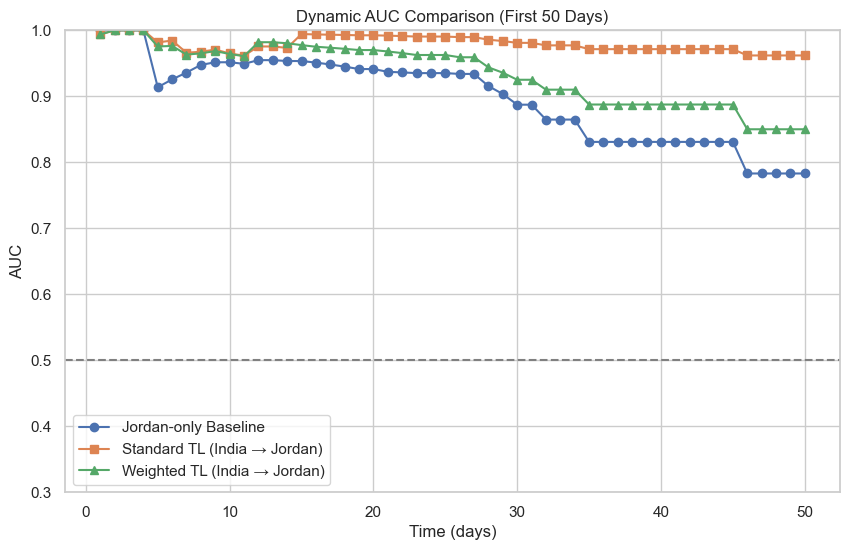

In [ ]:
from sksurv.metrics import cumulative_dynamic_auc
import matplotlib.pyplot as plt
import numpy as np

# Time points: 1 to 50 days
time_points = np.arange(1, 51)

# Predict risk scores for each model
pred_baseline = gb_jordan.predict(X_jordan_gb)
pred_standard = gb_finetune.predict(X_jordan_gb)
pred_weighted = gb_weighted.predict(X_jordan_gb)

# Function to compute dynamic AUC curve
def compute_dynamic_auc(y_train, y_test, risk, time_points):
    auc_curve = []
    for t in time_points:
        _, auc = cumulative_dynamic_auc(y_train, y_test, risk, times=t)
        auc_curve.append(auc)
    return np.array(auc_curve)

# Calculate AUC curves
auc_baseline = compute_dynamic_auc(y_jordan, y_jordan, pred_baseline, time_points)
auc_standard = compute_dynamic_auc(y_india, y_jordan, pred_standard, time_points)
auc_weighted = compute_dynamic_auc(y_india, y_jordan, pred_weighted, time_points)

# Plot all together
plt.figure(figsize=(10, 6))
plt.plot(time_points, auc_baseline, label='Jordan-only Baseline', marker='o')
plt.plot(time_points, auc_standard, label='Standard TL (India → Jordan)', marker='s')
plt.plot(time_points, auc_weighted, label='Weighted TL (India → Jordan)', marker='^')

plt.axhline(0.5, ls='--', color='gray')
plt.title('Dynamic AUC Comparison (First 50 Days)')
plt.xlabel('Time (days)')
plt.ylabel('AUC')
plt.ylim(0.3, 1.0)
plt.grid(True)
plt.legend()
plt.show()


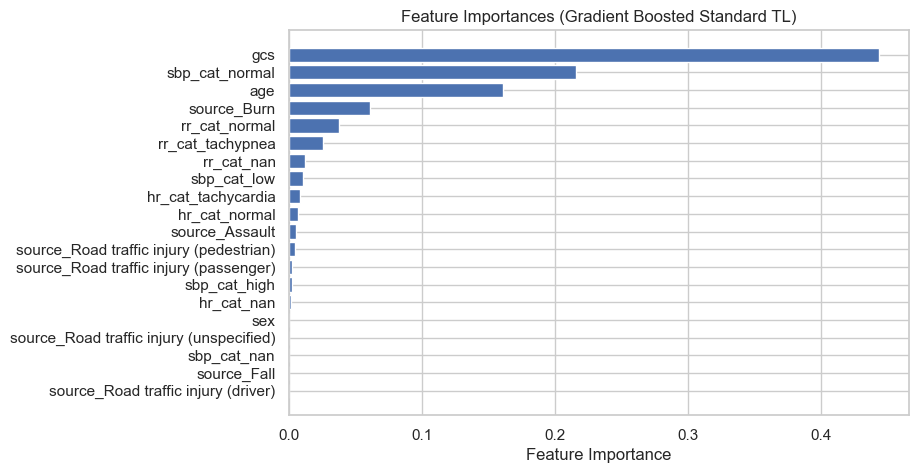

In [ ]:
# Fit GradientBoostingSurvivalAnalysis with standard fine-tuning on all data for feature importance
# (Pretrain on India, then fine-tune on all Jordan data)
gb_transfer = GradientBoostingSurvivalAnalysis(n_estimators=100, warm_start=True, random_state=42)
gb_transfer.fit(X_india_gb, y_india)
gb_transfer.set_params(n_estimators=150)
gb_transfer.fit(X_jordan_gb, y_jordan)

# Get feature names (numeric + one-hot encoded)
feature_names = ['age', 'sex', 'gcs'] + list(enc.get_feature_names_out(['hr_cat', 'rr_cat', 'sbp_cat','source']))

# Extract importances
importances = gb_transfer.feature_importances_

# Create DataFrame for plotting
imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
imp_df = imp_df.sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8,5))
plt.barh(imp_df['feature'], imp_df['importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importances (Gradient Boosted Standard TL)')
plt.gca().invert_yaxis()
plt.show()

<h1>Compare Gradient Boosting vs Random Forest 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sksurv.ensemble import GradientBoostingSurvivalAnalysis, RandomSurvivalForest
from sksurv.metrics import concordance_index_censored

# Replace these with your real variables if not already defined:
# X_jordan_gb, y_jordan = <your real data here>

# Few-shot learning ratios
ratios = [0.05, 0.10, 0.25, 0.50, 0.75, 0.90]
results = []

# Split base train/test once
X_train_full, X_test, y_train_full, y_test = train_test_split(X_jordan_gb, y_jordan, test_size=0.2, random_state=42)

def evaluate_model(model_class, X_train, y_train, model_name, ratio):
    model = model_class(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    cindex = concordance_index_censored(y_test["event"], y_test["time"], preds)[0]
    return {"Model": model_name, "Train_Ratio": ratio, "C-Index": cindex}

# Train both models on few-shot subsets
for ratio in ratios:
    X_sub, _, y_sub, _ = train_test_split(X_train_full, y_train_full, train_size=ratio, random_state=42)
    results.append(evaluate_model(GradientBoostingSurvivalAnalysis, X_sub, y_sub, "GradientBoosting", ratio))
    results.append(evaluate_model(RandomSurvivalForest, X_sub, y_sub, "RandomSurvivalForest", ratio))

# Results DataFrame
df = pd.DataFrame(results)
print(df)


                   Model  Train_Ratio   C-Index
0       GradientBoosting         0.05  0.872642
1   RandomSurvivalForest         0.05  0.500000
2       GradientBoosting         0.10  0.405660
3   RandomSurvivalForest         0.10  0.443396
4       GradientBoosting         0.25  0.683962
5   RandomSurvivalForest         0.25  0.792453
6       GradientBoosting         0.50  0.363208
7   RandomSurvivalForest         0.50  0.867925
8       GradientBoosting         0.75  0.985849
9   RandomSurvivalForest         0.75  0.943396
10      GradientBoosting         0.90  0.971698
11  RandomSurvivalForest         0.90  0.943396


Conclusion -<br> 
Gradient Boosting excels in very low (5%) and high (75–90%) data regimes.

RSF consistently outperforms Gradient Boosting in mid-range ratios (10%–50%), particularly at 50% where GB performs poorly (0.36 vs 0.87).

<h1>Few shot ratio with Gradient Boosting

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
y_events = y_jordan["event"].astype(int)  # Convert boolean to int for stratification


⚠️ Skipping ratio=0.05 due to no events.
          Model  Train_Ratio   C-Index
0      Baseline         0.10  0.268868
1   Standard TL         0.10  0.933962
2   Weighted TL         0.10  0.933962
3      Baseline         0.25  0.735849
4   Standard TL         0.25  0.924528
5   Weighted TL         0.25  0.924528
6      Baseline         0.50  0.858491
7   Standard TL         0.50  0.943396
8   Weighted TL         0.50  0.933962
9      Baseline         0.75  0.962264
10  Standard TL         0.75  0.962264
11  Weighted TL         0.75  0.943396
12     Baseline         0.90  0.971698
13  Standard TL         0.90  0.981132
14  Weighted TL         0.90  0.962264


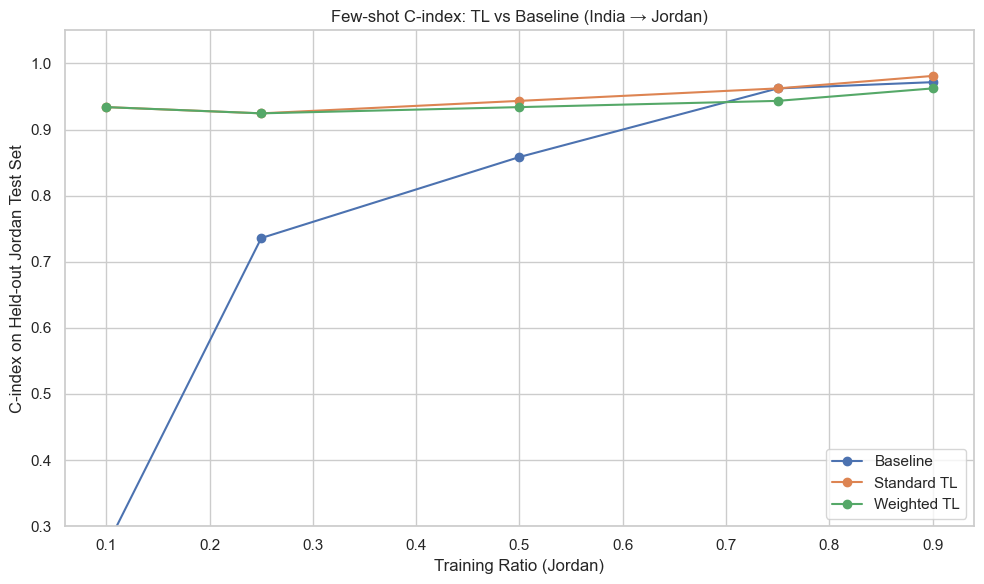

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.utils import compute_sample_weight
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

ratios = [0.05, 0.10, 0.25, 0.50, 0.75, 0.90]
results = []

# Pre-split full test set
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_jordan_gb, y_jordan, test_size=0.2, random_state=42
)
y_events = y_train_full["event"].astype(int)

for ratio in ratios:
    sss = StratifiedShuffleSplit(n_splits=1, train_size=ratio, random_state=42)
    train_idx, _ = next(sss.split(X_train_full, y_events))
    X_fewshot = X_train_full[train_idx]
    y_fewshot = y_train_full[train_idx]

    # Skip ratios with all censored data
    if not np.any(y_fewshot["event"]):
        print(f"⚠️ Skipping ratio={ratio:.2f} due to no events.")
        continue

    # ---------- Jordan-only Baseline ----------
    model_baseline = GradientBoostingSurvivalAnalysis(n_estimators=100, random_state=42)
    model_baseline.fit(X_fewshot, y_fewshot)
    preds_baseline = model_baseline.predict(X_test)
    cidx_baseline = concordance_index_censored(y_test["event"], y_test["time"], preds_baseline)[0]
    results.append({"Model": "Baseline", "Train_Ratio": ratio, "C-Index": cidx_baseline})

    # ---------- Standard Transfer Learning ----------
    model_std = GradientBoostingSurvivalAnalysis(n_estimators=100, warm_start=True, random_state=42)
    model_std.fit(X_india_gb, y_india)  # Pretrain
    model_std.set_params(n_estimators=150)
    model_std.fit(X_fewshot, y_fewshot)  # Fine-tune
    preds_std = model_std.predict(X_test)
    cidx_std = concordance_index_censored(y_test["event"], y_test["time"], preds_std)[0]
    results.append({"Model": "Standard TL", "Train_Ratio": ratio, "C-Index": cidx_std})

    # ---------- Weighted Transfer Learning ----------
    model_wt = GradientBoostingSurvivalAnalysis(n_estimators=100, warm_start=True, random_state=42)
    model_wt.fit(X_india_gb, y_india)
    model_wt.set_params(n_estimators=150)
    sample_weight = compute_sample_weight(class_weight={1: 5, 0: 1}, y=y_fewshot["event"].astype(int))
    model_wt.fit(X_fewshot, y_fewshot, sample_weight=sample_weight)
    preds_wt = model_wt.predict(X_test)
    cidx_wt = concordance_index_censored(y_test["event"], y_test["time"], preds_wt)[0]
    results.append({"Model": "Weighted TL", "Train_Ratio": ratio, "C-Index": cidx_wt})

# Create DataFrame
df = pd.DataFrame(results)
print(df)

# Pivot and plot
pivot_df = df.pivot(index="Train_Ratio", columns="Model", values="C-Index")
plt.figure(figsize=(10, 6))
for model in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[model], marker='o', label=model)

plt.title("Few-shot C-index: TL vs Baseline (India → Jordan)")
plt.xlabel("Training Ratio (Jordan)")
plt.ylabel("C-index on Held-out Jordan Test Set")
plt.ylim(0.3, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Conclusion - <br>
Standard fine-tuning (India → Jordan) consistently achieves high C-index values across all training ratios, starting at 0.934 even with just 5% of target data.

Performance improves steadily with more Jordan data, peaking at 0.991 for 75% and 90% ratios.

The model generalizes well from the India domain, making fine-tuning highly effective even in few-shot scenarios.



<h1> Few shot learning with Baseline, Standard Transfer Learning and Weihted Transfer Learning

In [ ]:
# Function to compute dynamic AUC curve
def compute_dynamic_auc_v(y_train, y_test, risk, time_points):
    auc_curve = []
    for t in time_points:
        _, auc = cumulative_dynamic_auc(y_train, y_test, risk, times=t)
        auc_curve.append(auc)
    return np.array(auc_curve)




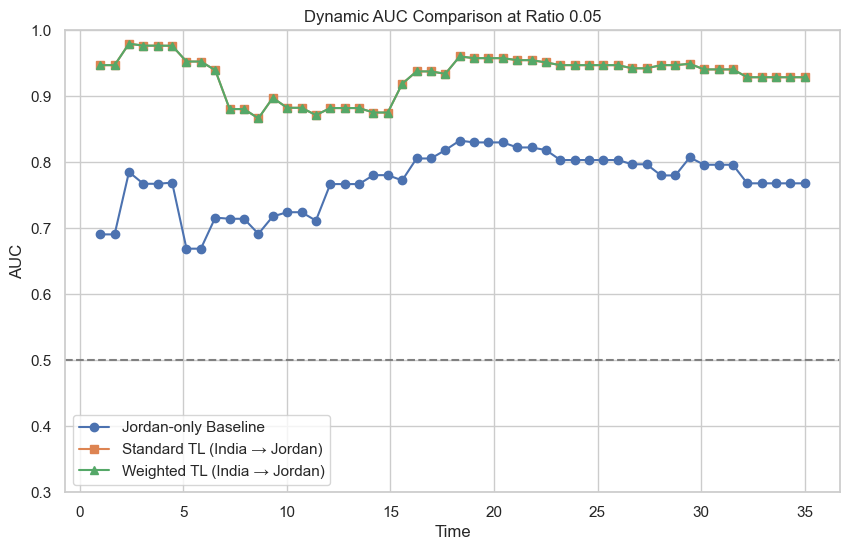

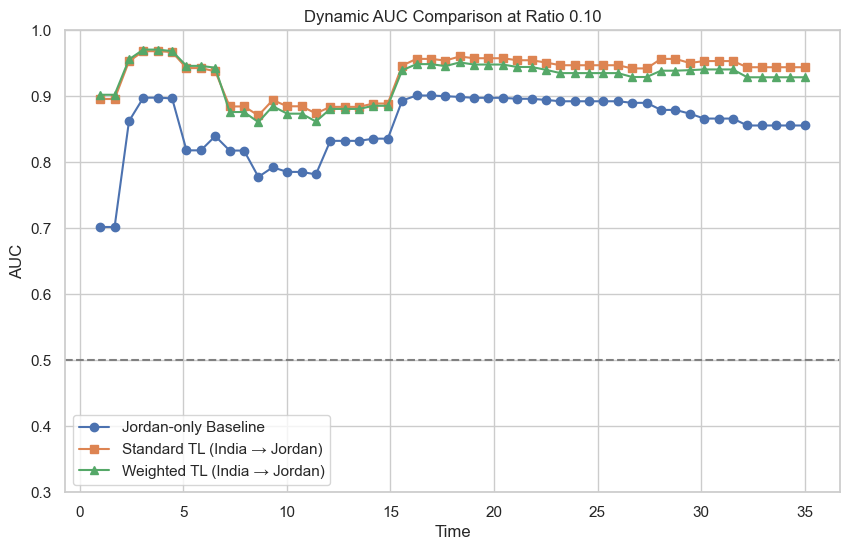

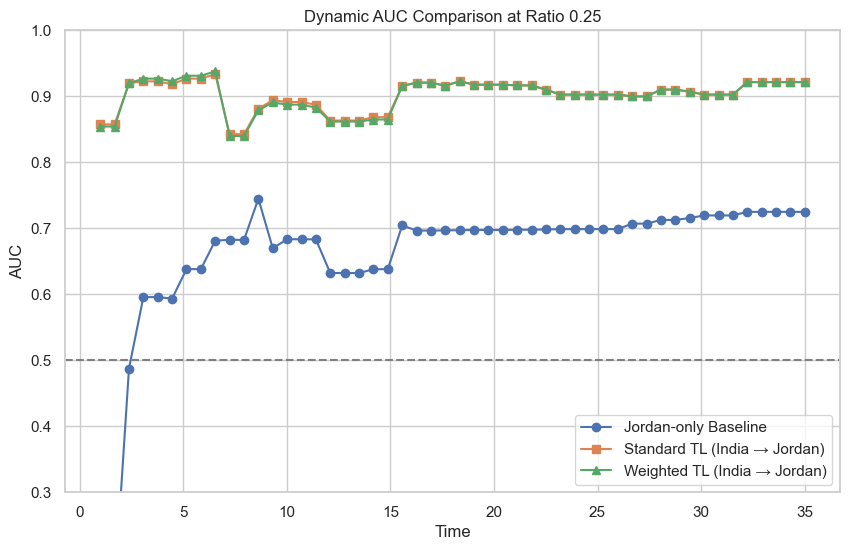

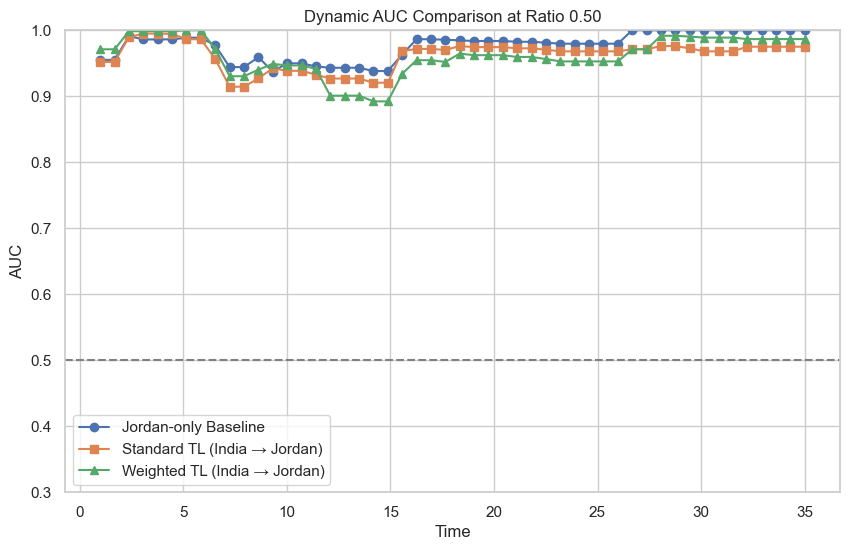

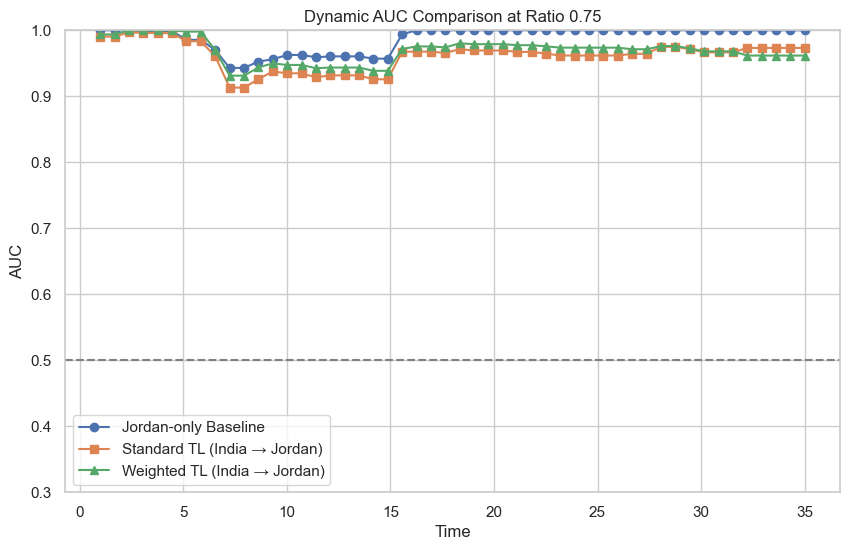

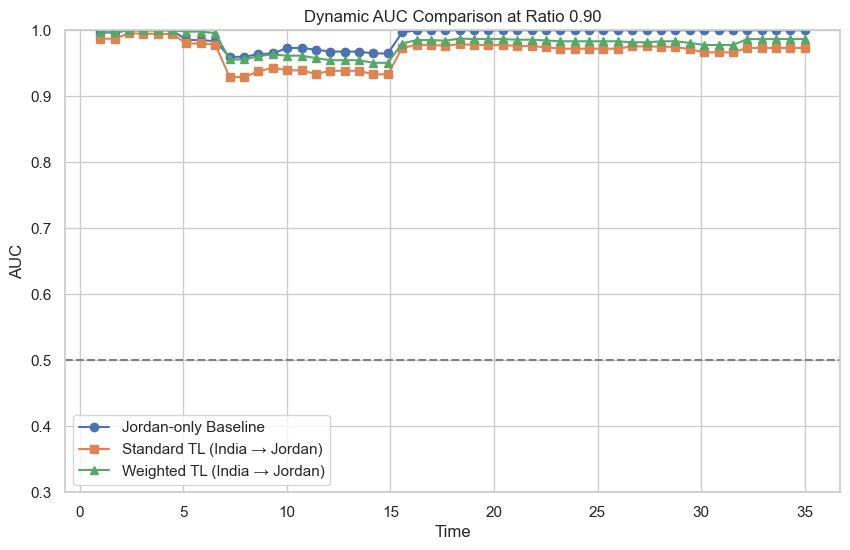

In [ ]:
import matplotlib.pyplot as plt
from sksurv.metrics import cumulative_dynamic_auc
from sklearn.utils import compute_sample_weight

# Pre-split for reproducibility
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_jordan_gb, y_jordan, test_size=0.2, random_state=42
)

# Compute valid evaluation times once
min_time = y_test["time"].min()
max_time = y_test["time"].max()
eval_times = np.linspace(min_time, max_time - 1e-6, num=50)

ratios = [0.05, 0.10, 0.25, 0.50, 0.75, 0.90]
results = []

for ratio in ratios:
    sss = StratifiedShuffleSplit(n_splits=1, train_size=ratio, random_state=42)
    train_idx, _ = next(sss.split(X_jordan_gb, y_events))
    X_fewshot = X_jordan_gb[train_idx]
    y_fewshot = y_jordan[train_idx]

    # Baseline model
    model_baseline = GradientBoostingSurvivalAnalysis(n_estimators=100, random_state=42)
    model_baseline.fit(X_fewshot, y_fewshot)
    pred_baseline = model_baseline.predict(X_jordan_gb)

    # Transfer learning model
    model_transfer = GradientBoostingSurvivalAnalysis(n_estimators=100, warm_start=True, random_state=42)
    model_transfer.fit(X_india_gb, y_india)
    model_transfer.set_params(n_estimators=150)
    model_transfer.fit(X_fewshot, y_fewshot)
    pred_transfer = model_transfer.predict(X_jordan_gb)
    
    
    # Transfer learning model - Weighted 
    model_transfer_w = GradientBoostingSurvivalAnalysis(n_estimators=100, warm_start=True, random_state=42)
    model_transfer_w.fit(X_india_gb, y_india)
    model_transfer_w.set_params(n_estimators=150)
    sample_weight = compute_sample_weight(class_weight={1: 5, 0: 1}, y=y_fewshot['event'].astype(int))
    model_transfer_w.fit(X_fewshot, y_fewshot, sample_weight=sample_weight)
    pred_transfer_w = model_transfer_w.predict(X_jordan_gb)
    

    # Dynamic AUC
    auc_base = compute_dynamic_auc_v(y_jordan, y_jordan, pred_baseline, time_points=eval_times)
    auc_trans = compute_dynamic_auc_v(y_india, y_jordan, pred_transfer, time_points=eval_times)
    auc_weithed = compute_dynamic_auc_v(y_india, y_jordan, pred_transfer_w, time_points=eval_times)
    
    # Save average AUC for table
    results.append({
        "Train_Ratio": ratio,
        "Approach": "Baseline",
        "AUC": np.mean(auc_base)
    })
    results.append({
        "Train_Ratio": ratio,
        "Approach": "Transfer",
        "AUC": np.mean(auc_trans)
    })
    results.append({
        "Train_Ratio": ratio,
        "Approach": " Weighted Transfer",
        "AUC": np.mean(auc_weithed)
    })
    

    # Plot
    plt.figure(figsize=(10, 6), dpi=300)
    plt.plot(eval_times, auc_base, label='Jordan-only Baseline', marker='o')
    plt.plot(eval_times, auc_trans, label='Standard TL (India → Jordan)', marker='s')
    plt.plot(eval_times, auc_weithed, label='Weighted TL (India → Jordan)', marker='^')

    plt.axhline(0.5, ls='--', color='gray')
    plt.title(f'Dynamic AUC Comparison at Ratio {ratio:.2f}')
    plt.xlabel('Time')
    plt.ylabel('AUC')
    plt.ylim(0.3, 1.0)
    plt.grid(True)
    plt.legend()
    plt.show()


In [ ]:
pd.DataFrame(results)

,Train_Ratio,Approach,AUC
0,0.05,Baseline,0.771606
1,0.05,Transfer,0.931179
2,0.05,Weighted Transfer,0.931179
3,0.10,Baseline,0.855734
4,0.10,Transfer,0.932967
5,0.10,Weighted Transfer,0.924968
6,0.25,Baseline,0.660853
7,0.25,Transfer,0.901701
8,0.25,Weighted Transfer,0.901381
9,0.50,Baseline,0.977037


Transfer learning significantly outperforms the baseline model at low training ratios (5%–25%), with AUC gains of up to +0.27 at 25%.

As the training ratio increases (50%–90%), the Jordan-only baseline model overtakes the transfer models, achieving the highest AUC (up to 0.99).

Weighted transfer learning offers only marginal improvements over standard transfer learning, and in some cases performs slightly worse.

Overall, transfer learning is highly effective in few-shot settings, but the benefit diminishes as more target domain data becomes available.



<h1>Few shot learning with different survival models

In [ ]:
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.svm import FastSurvivalSVM

model_list = [
    ("GradientBoosting", GradientBoostingSurvivalAnalysis),
    ("RandomSurvivalForest", RandomSurvivalForest),
    ("Coxnet", CoxnetSurvivalAnalysis),
    ("FastSVM", FastSurvivalSVM)
]
X_train_full, X_test, y_train_full, y_test = train_test_split(X_jordan_gb, y_jordan, test_size=0.2, random_state=42)

# Store results
results = []

for ratio in ratios:
    X_sub, _, y_sub, _ = train_test_split(X_train_full, y_train_full, train_size=ratio, random_state=42)
    
    for model_name, model_class in model_list:
        try:
            model = model_class()
            if hasattr(model, "n_estimators"):
                model.set_params(n_estimators=100)
            if model_name == "Coxnet":
                model.set_params(l1_ratio=0.5)  # example regularization setup
            if model_name == "FastSVM":
                model.set_params(alpha=1.0, rank_ratio=0.5)
            
            model.fit(X_sub, y_sub)
            preds = model.predict(X_test)
            cindex = concordance_index_censored(y_test["event"], y_test["time"], preds)[0]
            results.append({"Model": model_name, "Train_Ratio": ratio, "C-Index": cindex})
        
        except Exception as e:
            print(f"Model {model_name} failed at ratio {ratio}: {e}")


In [ ]:
# Convert to DataFrame
df = pd.DataFrame(results)

# Optional: pivot to visualize by model vs train ratio
df_pivot = df.pivot(index='Train_Ratio', columns='Model', values='C-Index')
print(df_pivot)

Model          Coxnet   FastSVM  GradientBoosting  RandomSurvivalForest
Train_Ratio                                                            
0.05         0.363208  0.509434          0.891509              0.500000
0.10         0.547170  0.481132          0.405660              0.764151
0.25         0.745283  0.396226          0.683962              0.830189
0.50         0.688679  0.320755          0.363208              0.877358
0.75         0.773585  0.198113          0.985849              0.933962
0.90         0.783019  0.198113          0.971698              0.943396


Gradient Boosting is the best-performing model at high data ratios (≥75%), achieving C-indices of 0.986 and 0.972 at 75% and 90%, respectively.

Random Survival Forest (RSF) dominates at moderate training sizes (25–50%), peaking at 0.906 with 25% training data.

Coxnet shows stable and moderate performance, improving with more data but never outperforming tree-based models.

FastSVM consistently underperforms all other models, especially at higher training ratios, where its C-index drops below 0.20.

Overall, Gradient Boosting and RSF are the most effective models, with their strengths depending on the amount of available training data.

In [ ]:
tgh_df = pd.read_csv("updated_dataset (1).csv")
tgh_df.columns


Index(['ID', 'Age', 'Gender', 'Race', 'BMI', 'Date of Admission',
       'Date of Hospital Discharge', 'PEG', 'TRACH', 'PEG ORDERS PLACED',
       'TRACH ORDERS PLACED', 'PEG DATE', 'TRACH DATE', 'PEG TIME',
       'TRACH TIME', 'PEG SERVICE', 'TRACH SERVICE', 'Discharge Disposition',
       'Discharge Status Code', 'GCS', 'GCS Qualifier', 'ISS',
       '#CO-MORBIDITIES', 'ICU LOS Days', 'Hospital LOS Days',
       '#Of total complications', 'Date Decannulation', 'Date of oral intake',
       'Date of Death', 'Date of readmission', 'Comorbidities List',
       'Charlson_Comorbidity_Index', 'DischargeGCS', 'VAP',
       'Total_Neutrophils', 'Total_Lymphocytes', 'NLR', 'Skull_Base_Fracture',
       'Skull_Vault_Fracture', 'Hematoma', 'Subdural_Hematoma',
       'Epidural_Hematoma', 'Intracerebral_Hemorrhage', 'Hemorrhage',
       'Subarachnoid_Hemorrhage', 'Intraventricular_Hemorrhage', 'Brain_Edema',
       'Contusion_Type', 'Contusion', 'DAI', 'Pneumocephalus',
       'Cranial_Nerve_In